In [1]:
import os
import sys
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

cwd = os.getcwd()
model_path = os.path.abspath(os.path.join(cwd, os.pardir, 'models'))
sys.path.append(model_path)
from cumul_diamond_ODE_model import *
from cumul_treated_diamond_ODE_model import *

In [2]:
untreated_model = cumulDiamondODEModel()
treated_model = cumulTreatedDiamondODEModel()

t_interventions = [0, 7, 14, 21]
t_final = 31
n_tot = 100
Np = 2666
Nc = 1045

times = np.linspace(0, t_final, n_tot)

n_simulations = 100
inferred_parameters = pd.read_csv('../data/inferred_parameters.csv')
data = pd.read_csv('../data/data_cases_symp.csv')
data['onset_date'] = pd.to_datetime(data['onset_date'], format='%d-%b')
all_untreated_simulated_values = []
all_treated_simulated_values = []

pintp = int(1)
pintc = int(1)
effp = 0.7
effc = effp

for _ in range(n_simulations):
    treated_values = {t: None for t in t_interventions}  # Initialize treated values for each intervention time
    
    idx = np.random.randint(0, inferred_parameters.shape[0])
    selected_params = inferred_parameters.iloc[idx].to_list()
    untreated_values = untreated_model.simulate(selected_params[:8], times)

    for t_intervention in t_interventions:
        treated_time = np.linspace(t_intervention, t_final, int((t_final - t_intervention) * n_tot / t_final))
        interv_index = (np.abs(times - t_intervention)).argmin()

        if t_intervention == 0:
            # For t_intervention == 0, don't pass y0
            treated_values[t_intervention] = treated_model.simulate(selected_params[:8] + [effp, effc, pintp, pintc], treated_time)
        else:
            y0 = np.concatenate((untreated_values[interv_index, :], [pintp * untreated_values[interv_index, 0], pintc * untreated_values[interv_index, 1]]))
            y0[0] = (1 - pintp) * untreated_values[interv_index, 0]
            y0[1] = (1 - pintc) * untreated_values[interv_index, 1]
            treated_values[t_intervention] = treated_model.simulate(selected_params[:8] + [effp, effc, pintp, pintc], treated_time, y0)
    
    all_untreated_simulated_values.append(untreated_values)
    all_treated_simulated_values.append(treated_values)

/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_diamond_ODE_model.py:67: RuntimeWarning: overflow encountered in exp
  bcp = (bbarcp + a2) * ccp * (1 - b1 / (1 + np.exp(-b2 * (t - tcp - a))))
/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_diamond_ODE_model.py:68: RuntimeWarning: overflow encountered in exp
  bcc = (bbarcc + a2) * ccc * (1 - b1 / (1 + np.exp(-b2 * (t - tcc - a))))
/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_diamond_ODE_model.py:69: RuntimeWarning: overflow encountered in exp
  bpc = (bbarpc + a2) * cpc * (1 - b1 / (1 + np.exp(-b2 * (t - tpc - a))))
/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_diamond_ODE_model.py:70: RuntimeWarning: overflow encountered in exp
  bpp = (bbarpp + a2) * cpp * (1 - b1 / (1 + np.exp(-b2 * (t - tpp - a))))
/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_treated_diamond_ODE_model.py:82: RuntimeWarning: 

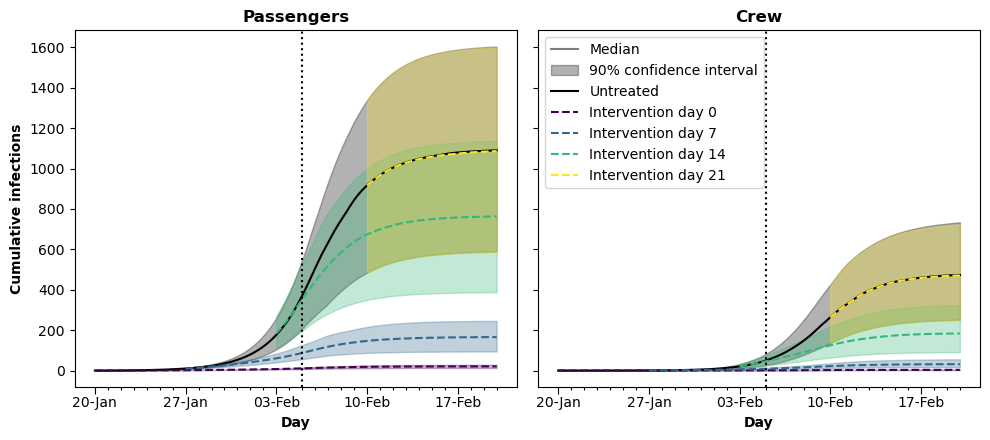

In [3]:
# Initialize plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True)

colors = plt.cm.viridis(np.linspace(0, 1, len(t_interventions)))

# Plot for passengers
untreated_passengers = np.array([sim[:, -2] for sim in all_untreated_simulated_values])
untreated_lower, untreated_upper = np.percentile(untreated_passengers, [5, 95], axis=0)
untreated_median = np.median(untreated_passengers, axis=0)

# Plotting
ax1.fill_between(times, untreated_lower, untreated_upper, color='black', alpha=0.3)
ax1.plot(times, untreated_median, label='Untreated', color='black')

for idx, t_intervention in enumerate(t_interventions):
    treated_time = np.linspace(t_intervention, t_final, int((t_final - t_intervention)*n_tot/t_final))
    # Extract data for untreated and treated (at this intervention) simulations
    treated_passengers = np.array([sim[t_intervention][:, 22] for sim in all_treated_simulated_values])

    # Calculate percentiles and median
    treated_lower, treated_upper = np.percentile(treated_passengers, [5, 95], axis=0)
    treated_median = np.median(treated_passengers, axis=0)

    ax1.fill_between(treated_time, treated_lower, treated_upper, color=colors[idx], alpha=0.3)
    ax1.plot(treated_time, treated_median, '--', label=f'Intervention day {t_intervention}', color=colors[idx])

# Extract data for untreated and treated (at this intervention) simulations
untreated_crew = np.array([sim[:, -1] for sim in all_untreated_simulated_values])
untreated_lower, untreated_upper = np.percentile(untreated_crew, [5, 95], axis=0)
untreated_median = np.median(untreated_crew, axis=0)

# Plotting untreated
ax2.plot(np.nan, np.nan, label='Median', color='grey')
ax2.fill_between([np.nan, np.nan], [np.nan, np.nan], [np.nan, np.nan], color='black', alpha=0.3, label='90% confidence interval')

ax2.fill_between(times, untreated_lower, untreated_upper, color='black', alpha=0.3)
ax2.plot(times, untreated_median, label='Untreated', color='black')

# Plot for crew
for idx, t_intervention in enumerate(t_interventions):
    treated_time = np.linspace(t_intervention, t_final, int((t_final - t_intervention)*n_tot/t_final))
    # Corrected line: iterate over all_treated_simulated_values directly
    treated_crew = np.array([sim[t_intervention][:, 23] for sim in all_treated_simulated_values])

    # Calculate percentiles and median
    treated_lower, treated_upper = np.percentile(treated_crew, [5, 95], axis=0)
    treated_median = np.median(treated_crew, axis=0)

    # Plotting treated, starting from intervention time
    ax2.fill_between(treated_time, treated_lower, treated_upper, color=colors[idx], alpha=0.3)
    ax2.plot(treated_time, treated_median, '--', label=f'Intervention day {t_intervention}', color=colors[idx])

# Setting titles and labels
ax1.set_title('Passengers', weight='bold')
ax1.set_xlabel('Day', weight='bold')
ax1.set_ylabel('Cumulative infections', weight='bold')

ax2.set_title('Crew', weight='bold')
ax2.set_xlabel('Day', weight='bold')
ax2.legend(loc='upper left')

# Set x-axis ticks and labels for every day, but only label every 7th day
full_indices = data.index  # Ticks for every day
full_dates = data['onset_date'].dt.strftime('%d-%b')  # Labels for every day

label_interval = 7
labels = ['' if (i % label_interval != 0) else date for i, date in enumerate(full_dates)]

# Apply the changes to both subplots
for ax in (ax1, ax2):
    ax.set_xticks(full_indices)
    ax.set_xticklabels(labels)
    
    # Set the length of the tick marks
    for i, tick in enumerate(ax.xaxis.get_major_ticks()):
        if i % label_interval == 0:  # Dates
            tick.tick1line.set_markersize(5)  # Default tick length for non-dates
            tick.tick2line.set_markersize(5)  # Default tick length for non-dates
        else:  # Non-dates
            tick.tick1line.set_markersize(2)  # Default tick length for non-dates
            tick.tick2line.set_markersize(2)  # Default tick length for non-dates

    ax.axvline(x=16, color='black', linestyle=':')

plt.tight_layout()
plt.show()

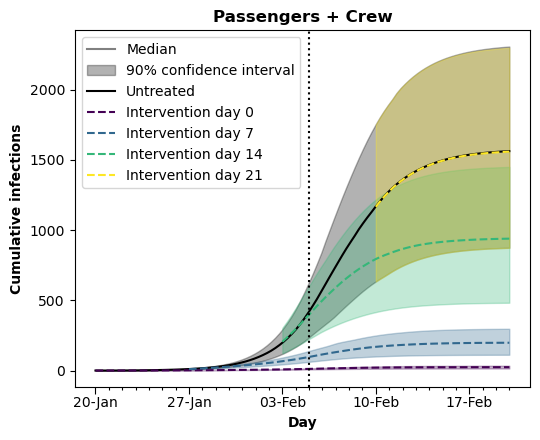

In [4]:
# Initialize a single plot
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))

colors = plt.cm.viridis(np.linspace(0, 1, len(t_interventions)))

# For untreated scenarios, sum the infections for passengers and crew
untreated_total = np.array([sim[:, -2] + sim[:, -1] for sim in all_untreated_simulated_values])

# Calculate the percentiles and median for the total infections
untreated_lower, untreated_upper = np.percentile(untreated_total, [5, 95], axis=0)
untreated_median = np.median(untreated_total, axis=0)

# Plotting untreated
ax.plot(np.nan, np.nan, label='Median', color='grey')
ax.fill_between([np.nan, np.nan], [np.nan, np.nan], [np.nan, np.nan], color='black', alpha=0.3, label='90% confidence interval')

# Plotting for untreated
ax.fill_between(times, untreated_lower, untreated_upper, color='black', alpha=0.3)
ax.plot(times, untreated_median, label='Untreated', color='black')

# For treated scenarios, sum the infections for passengers and crew
for idx, t_intervention in enumerate(t_interventions):
    treated_time = np.linspace(t_intervention, t_final, int((t_final - t_intervention) * n_tot / t_final))
    treated_total = np.array([sim[t_intervention][:, 22] + sim[t_intervention][:, 23] for sim in all_treated_simulated_values])

    # Calculate the percentiles and median for the total infections
    treated_lower, treated_upper = np.percentile(treated_total, [5, 95], axis=0)
    treated_median = np.median(treated_total, axis=0)

    # Plotting for treated scenarios
    ax.fill_between(treated_time, treated_lower, treated_upper, color=colors[idx], alpha=0.3)
    ax.plot(treated_time, treated_median, '--', label=f'Intervention day {t_intervention}', color=colors[idx])

# Setting titles and labels
ax.set_title('Passengers + Crew', weight='bold')
ax.set_xlabel('Day', weight='bold')
ax.set_ylabel('Cumulative infections', weight='bold')
ax.legend(loc='upper left')

full_indices = data.index  # Ticks for every day
full_dates = data['onset_date'].dt.strftime('%d-%b')  # Labels for every day

label_interval = 7
labels = ['' if (i % label_interval != 0) else date for i, date in enumerate(full_dates)]

ax.set_xticks(full_indices)
ax.set_xticklabels(labels)

# Set the length of the tick marks
for i, tick in enumerate(ax.xaxis.get_major_ticks()):
    if i % label_interval == 0:  # Dates
        tick.tick1line.set_markersize(5)  # Default tick length for non-dates
        tick.tick2line.set_markersize(5)  # Default tick length for non-dates
    else:  # Non-dates
        tick.tick1line.set_markersize(2)  # Default tick length for non-dates
        tick.tick2line.set_markersize(2)  # Default tick length for non-dates

ax.axvline(x=16, color='black', linestyle=':')

plt.tight_layout()

# Define the directory path and the filename
directory = '../figures'
filename = 'figure3a.svg'

# Check if the directory exists
if not os.path.exists(directory):
    # If the directory does not exist, create it
    os.makedirs(directory)

# Save the figure
plt.savefig(os.path.join(directory, filename), bbox_inches='tight')
plt.show()


In [ ]:
# Convert all_simulated_values to a 3D NumPy array for easier manipulation
all_untreated_simulated_values_array = np.array(all_untreated_simulated_values)
all_treated_simulated_values_array = np.array(all_treated_simulated_values)

np.save('../data/untreated_array.npy', all_untreated_simulated_values_array)
np.save('../data/treated_array.npy', all_treated_simulated_values_array)

In [ ]:
# Calculate median, 5th, and 95th percentiles for passengers (column 0) and crew (column 1) over time
median_passengers = np.median(all_untreated_simulated_values_array[:,:,10], axis=0)
percentile5_passengers = np.percentile(all_untreated_simulated_values_array[:,:,10], 5, axis=0)
percentile95_passengers = np.percentile(all_untreated_simulated_values_array[:,:,10], 95, axis=0)

median_crew = np.median(all_untreated_simulated_values_array[:,:,11], axis=0)
percentile5_crew = np.percentile(all_untreated_simulated_values_array[:,:,11], 5, axis=0)
percentile95_crew = np.percentile(all_untreated_simulated_values_array[:,:,11], 95, axis=0)


# Calculate median, 5th, and 95th percentiles for passengers (column 0) and crew (column 1) over time
median_treated_passengers = np.median(all_treated_simulated_values_array[:,:,10], axis=0)
percentile5_treated_passengers = np.percentile(all_treated_simulated_values_array[:,:,10], 5, axis=0)
percentile95_treated_passengers = np.percentile(all_treated_simulated_values_array[:,:,10], 95, axis=0)

median_treated_crew = np.median(all_treated_simulated_values_array[:,:,11], axis=0)
percentile5_treated_crew = np.percentile(all_treated_simulated_values_array[:,:,11], 5, axis=0)
percentile95_treated_crew = np.percentile(all_treated_simulated_values_array[:,:,11], 95, axis=0)

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# Plotting for passengers
axs[0].plot(times, median_passengers, label='Untreated', color='black')
axs[0].fill_between(times, percentile5_passengers, percentile95_passengers, color='black', alpha=0.2, label='5th to 95th Percentile Passengers')
axs[0].plot(times, median_treated_passengers, label='Treated', color='#31688e', linestyle='--')
axs[0].fill_between(times, percentile5_treated_passengers, percentile95_treated_passengers, color='#31688e', alpha=0.2, label='5th to 95th Percentile Passengers')
axs[0].plot(data.index, data['pass'], 'o', label='Actual Passengers', color='black', markerfacecolor='none')
axs[0].plot()
axs[0].set_title('Passengers', weight='bold')
axs[0].set_xlabel('Day', weight='bold')
axs[0].set_ylabel('No. symptomatic cases (known onset)', weight='bold')
axs[0].set_ylim(bottom=0)

# Plotting for crew
axs[1].plot(times, median_crew, label='Untreated median', color='black')
axs[1].fill_between(times, percentile5_crew, percentile95_crew, color='black', alpha=0.2)
axs[1].plot(times, median_treated_crew, label='Treated median', color='#31688e', linestyle='--')
axs[1].fill_between(times, percentile5_treated_crew, percentile95_treated_crew, color='#31688e', alpha=0.2)
axs[1].fill_between([np.nan, np.nan], [np.nan, np.nan], color='black', alpha=0.2, label='90% confidence interval')
axs[1].plot(data.index, data['crew'], 'o', label='Data', color='black', markerfacecolor='none')
axs[1].set_title('Crew', weight='bold')
axs[1].set_xlabel('Day', weight='bold')
axs[1].legend()
axs[1].set_ylim(bottom=0)

# Set x-axis ticks and labels for every day, but only label every 7th day
full_indices = data.index  # Ticks for every day
full_dates = data['onset_date'].dt.strftime('%d-%b')  # Labels for every day

label_interval = 7
labels = ['' if (i % label_interval != 0) else date for i, date in enumerate(full_dates)]

# Apply the changes to both subplots
for ax in axs:
    ax.set_xticks(full_indices)
    ax.set_xticklabels(labels)
    
    # Set the length of the tick marks
    for i, tick in enumerate(ax.xaxis.get_major_ticks()):
        if i % label_interval == 0:  # Dates
            tick.tick1line.set_markersize(5)  # Default tick length for non-dates
            tick.tick2line.set_markersize(5)  # Default tick length for non-dates
        else:  # Non-dates
            tick.tick1line.set_markersize(2)  # Default tick length for non-dates
            tick.tick2line.set_markersize(2)  # Default tick length for non-dates

    ax.axvline(x=16, color='black', linestyle=':')

plt.tight_layout()
plt.savefig('../figures/typical_infections_crew_passengers.svg', bbox_inches='tight')
plt.show()